# Model Interpretation for Pretrained ResNet Model

This notebook demonstrates how to apply model interpretability algorithms on pretrained ResNet model using a handpicked image and visualizes the attributions for each pixel by overlaying them on the image.

The interpretation algorithms that we use in this notebook are `Saliency` (aka Input Gradients), `Input * Gradients`, and `Integrated Gradients` (with and without noise tunnel),  `GradientShap`.
  
  **Note:** Before running this tutorial, please install the torchvision, PIL, and matplotlib packages.

In [2]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from matplotlib.colors import LinearSegmentedColormap

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

import torchvision
from torchvision import datasets
from torchvision import models
from torchvision import transforms

from captum.attr import Saliency
from captum.attr import InputXGradient
from captum.attr import IntegratedGradients
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

Always initialize your RNGs!

In [3]:
torch.manual_seed(0)
np.random.seed(0)

## Computing Attribution Maps with Captum


Loads pretrained Resnet model and sets it to eval mode

In [4]:
model = models.resnet18(pretrained=True)
model = model.eval()

/home/stefano/Devel/miniconda/envs/ml/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/stefano/Devel/miniconda/envs/ml/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloads the list of classes/labels for ImageNet dataset and reads them into the memory

In [5]:
!wget -P $HOME/.torch/models https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

--2022-11-03 18:41:50--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving localhost (localhost)... ::1, 127.0.0.1
Connecting to localhost (localhost)|::1|:8118... connected.
Proxy request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: ‘/home/stefano/.torch/models/imagenet_class_index.json.2’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0.1s    

2022-11-03 18:41:51 (343 KB/s) - ‘/home/stefano/.torch/models/imagenet_class_index.json.2’ saved [35363/35363]



In [6]:
labels_path = os.getenv("HOME") + '/.torch/models/imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)

Defines transformers and normalizing functions for the image.
It also loads an image from the `img/resnet/` folder that will be used for interpretation purposes.

In [7]:
!wget https://raw.githubusercontent.com/pytorch/captum/master/tutorials/img/resnet/swan-3299528_1280.jpg

--2022-11-03 18:42:01--  https://raw.githubusercontent.com/pytorch/captum/master/tutorials/img/resnet/swan-3299528_1280.jpg
Resolving localhost (localhost)... ::1, 127.0.0.1
Connecting to localhost (localhost)|::1|:8118... connected.
Proxy request sent, awaiting response... 200 OK
Length: 213579 (209K) [image/jpeg]
Saving to: ‘swan-3299528_1280.jpg.5’

swan-3299528_1280.j 100%[===================>] 208.57K  --.-KB/s    in 0.02s   

2022-11-03 18:42:02 (8.92 MB/s) - ‘swan-3299528_1280.jpg.5’ saved [213579/213579]



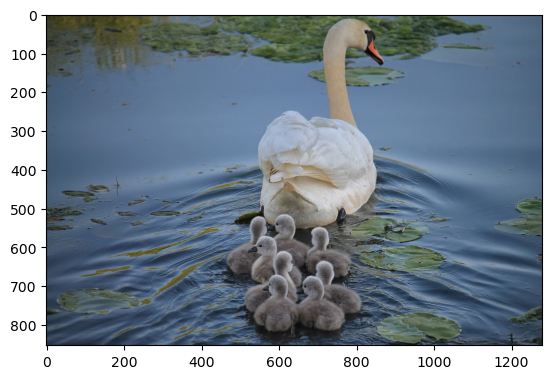

In [8]:
img = Image.open('swan-3299528_1280.jpg')

%matplotlib inline
plt.imshow(np.asarray(img))

In [9]:
transform = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
)

transformed_img = transform(img)

input = transform_normalize(transformed_img)
input = input.unsqueeze(0)

Predict the class of the input image

In [10]:
output = model(input)
output = F.softmax(output, dim=1)
#print('Output:', output)

prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()
predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')


Predicted: goose ( 0.45693379640579224 )


In [11]:
default_cmap = LinearSegmentedColormap.from_list(
    'doesntmatter', 
    [
        (0, '#ffffff'),
        (0.25, '#000000'),
        (1, '#000000')
    ],
    N=256
)

def visualize(image, attr):
    viz.visualize_image_attr(
        np.transpose(attr.squeeze().cpu().detach().numpy(), (1,2,0)),
        np.transpose(image.squeeze().cpu().detach().numpy(), (1,2,0)),
        method='heat_map',
        cmap=default_cmap,
        show_colorbar=True,
        sign='positive',
        outlier_perc=1
    )

Let's compute attributions using Integrated Gradients and visualize them on the image. Integrated gradients computes the integral of the gradients of the output of the model for the predicted class `pred_label_idx` with respect to the input image pixels along the path from the black image to our input image.

attribution map given by input * gradient


/home/stefano/Devel/miniconda/envs/ml/lib/python3.10/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


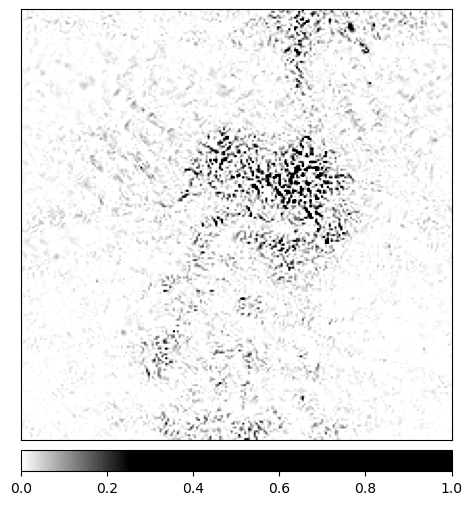

attribution map given by input gradient


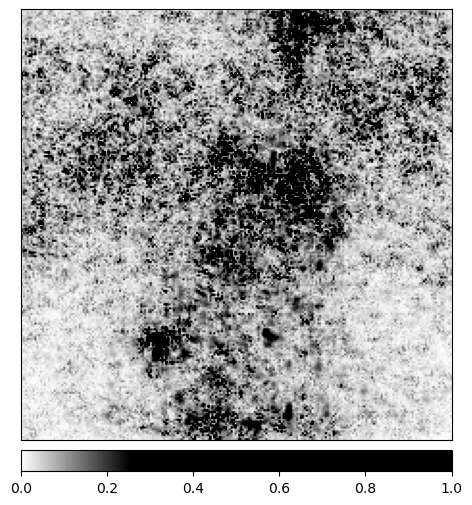

attribution map given by integrated gradient


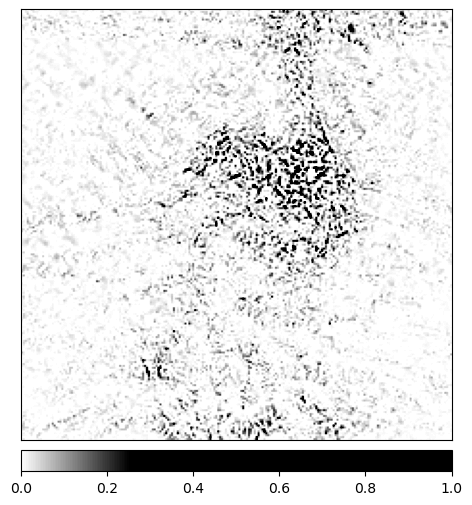

In [12]:
attr_methods = {
    'input gradient': Saliency(model),
    'input * gradient': InputXGradient(model),
    'integrated gradient': IntegratedGradients(model),
}

for name, am in sorted(attr_methods.items()):
    print('attribution map given by', name)
    attribution = am.attribute(input, target=pred_label_idx)
    visualize(transformed_img, attribution)

In [ ]:
for name, am in sorted(attr_methods.items()):
    print('attribution map given by smoothed', name)
    smoothed_am = NoiseTunnel(am)
    smoothed_attribution = smoothed_am.attribute(input, target=pred_label_idx)
    visualize(transformed_img, attribution)